## Load Data

In [ ]:
# CELEBA DATA LOADER CELL

import os
import pandas as pd
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

DATA_ROOT = "/content"   # change if needed
IMG_DIR = os.path.join(DATA_ROOT, "img_align_celeba")
subset_df = pd.read_csv('subset_df.csv', index_col=0)

# TRANSFORM (GAN STANDARD)
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5]
    )
])

# DATASET CLASS
class CelebADataset(Dataset):
    def __init__(self, attr_df, img_dir, transform=None):
        self.attr_df = attr_df
        self.img_dir = img_dir
        self.transform = transform
        self.image_names = attr_df.index.tolist()

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.img_dir, img_name)

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        attrs = self.attr_df.loc[img_name].values
        attrs = torch.tensor(attrs, dtype=torch.float32)

        return image, attrs

# DATASET
dataset = CelebADataset(
    subset_df,
    IMG_DIR,
    transform
)

# DATALOADER
loader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from tqdm import tqdm

### Hyperparameters

In [14]:
LATENT_DIM = 100
ATTR_DIM = 3   # Smiling, Eyeglasses, Male

FEATURE_G = 64
FEATURE_D = 64
LR = 2e-4
EPOCHS = 10

# CONDITIONAL GENERATOR

In [15]:
class ConditionalGenerator(nn.Module):
    def __init__(self):
        super().__init__()

        self.attr_fc = nn.Linear(ATTR_DIM, LATENT_DIM)

        self.net = nn.Sequential(
            nn.ConvTranspose2d(LATENT_DIM*2, FEATURE_G*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(FEATURE_G*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(FEATURE_G*8, FEATURE_G*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FEATURE_G*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(FEATURE_G*4, FEATURE_G*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FEATURE_G*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(FEATURE_G*2, FEATURE_G, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FEATURE_G),
            nn.ReLU(True),

            nn.ConvTranspose2d(FEATURE_G, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, attrs):
        attr_embed = self.attr_fc(attrs)
        attr_embed = attr_embed.unsqueeze(2).unsqueeze(3)

        x = torch.cat([noise, attr_embed], dim=1)
        return self.net(x)

In [16]:
class ConditionalDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.attr_fc = nn.Linear(ATTR_DIM, 64*64)

        self.net = nn.Sequential(
            nn.Conv2d(4, FEATURE_D, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),

            nn.Conv2d(FEATURE_D, FEATURE_D*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FEATURE_D*2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(FEATURE_D*2, FEATURE_D*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FEATURE_D*4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(FEATURE_D*4, FEATURE_D*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FEATURE_D*8),
            nn.LeakyReLU(0.2),

            nn.Conv2d(FEATURE_D*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img, attrs):
        attr_map = self.attr_fc(attrs).view(-1,1,64,64)
        x = torch.cat([img, attr_map], dim=1)
        return self.net(x).view(-1)

In [19]:
G = ConditionalGenerator().to(device)
D = ConditionalDiscriminator().to(device)

In [20]:
criterion = nn.BCELoss()

opt_G = torch.optim.Adam(G.parameters(), lr=LR, betas=(0.5, 0.999))
opt_D = torch.optim.Adam(D.parameters(), lr=LR, betas=(0.5, 0.999))

## Training Loop

In [21]:
fixed_noise = torch.randn(16, LATENT_DIM, 1, 1, device=device)
fixed_attrs = torch.randint(0,2,(16,ATTR_DIM), device=device).float()

for epoch in range(EPOCHS):

    for real, attrs in loader:

        real = real.to(device)
        attrs = attrs.to(device)

        batch_size = real.size(0)

        ### Train D ###
        noise = torch.randn(batch_size, LATENT_DIM, 1, 1, device=device)
        fake = G(noise, attrs)

        D_real = D(real, attrs)
        D_fake = D(fake.detach(), attrs)

        loss_D = (
            criterion(D_real, torch.ones_like(D_real)) +
            criterion(D_fake, torch.zeros_like(D_fake))
        ) / 2

        D.zero_grad()
        loss_D.backward()
        opt_D.step()

        ### Train G ###
        output = D(fake, attrs)
        loss_G = criterion(output, torch.ones_like(output))

        G.zero_grad()
        loss_G.backward()
        opt_G.step()

    print(f"Epoch {epoch+1} | D Loss {loss_D.item():.3f} | G Loss {loss_G.item():.3f}")

Epoch 1 | D Loss 0.447 | G Loss 1.957
Epoch 2 | D Loss 0.588 | G Loss 6.297
Epoch 3 | D Loss 0.409 | G Loss 6.014
Epoch 4 | D Loss 0.537 | G Loss 5.124
Epoch 5 | D Loss 0.395 | G Loss 2.434
Epoch 6 | D Loss 0.919 | G Loss 2.636
Epoch 7 | D Loss 0.356 | G Loss 4.147
Epoch 8 | D Loss 0.355 | G Loss 2.915
Epoch 9 | D Loss 0.445 | G Loss 4.765
Epoch 10 | D Loss 0.316 | G Loss 3.826


In [22]:
torch.save(G.state_dict(), "/content/conditional_generator.pth")

In [23]:
!ls /content

celeba.zip		   img_align_celeba	 subset_df.csv
conditional_generator.pth  list_attr_celeba.txt
drive			   sample_data


In [25]:
import torchvision

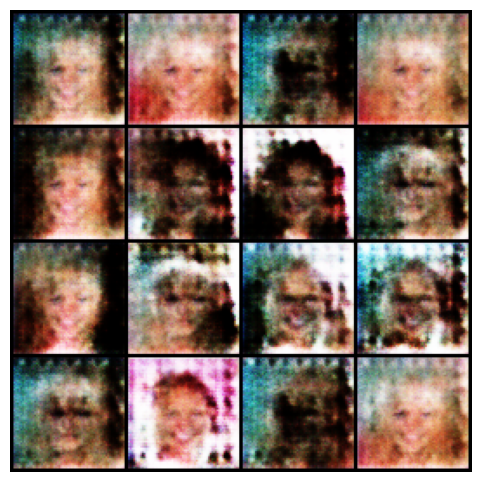

In [26]:
with torch.no_grad():
    fake = G(fixed_noise, fixed_attrs).cpu()
    fake = fake * 0.5 + 0.5

    grid = torchvision.utils.make_grid(fake, nrow=4)

    plt.figure(figsize=(6,6))
    plt.imshow(grid.permute(1,2,0))
    plt.axis("off")